### Requirements

Please install the following packages

`pip3 install scikit-learn`

`pip3 install tensorflow`

`pip3 install matplotlib`

`pip3 install gym`

In [13]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import warnings
import random
import gym

## Stocastic Gradient Descent

Suppose there was some true function: $y = w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3} + w_{4}x_{4} + w_{5}x_{5}$. We create random weights for this fuction, and try to find them through SGD. Go ahead and change the true weights! See what happens when you change the learning rate. 

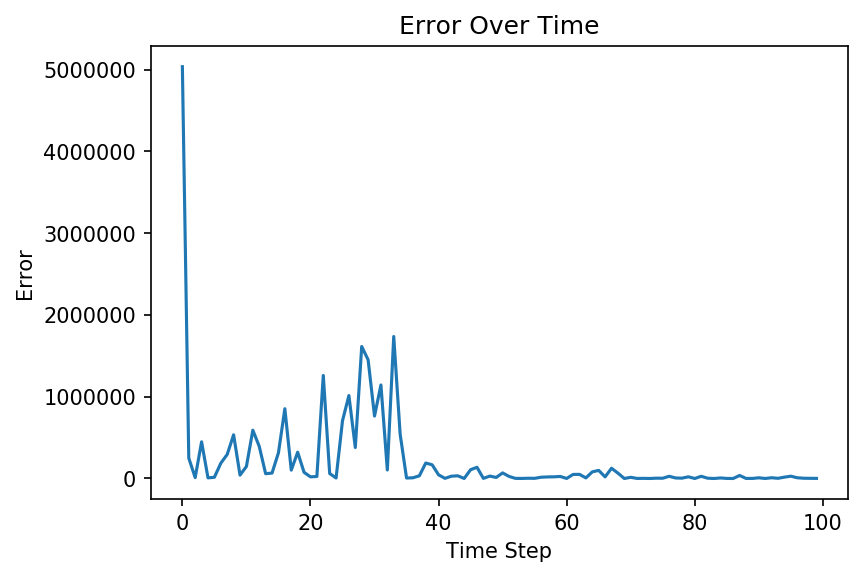

In [11]:
true_weights = np.array([20, 300, 2, 3, 5])
predicted_weights = np.zeros(len(true_weights))
errors = []
for i in range(100):
    point = np.random.randint(0, 10, len(true_weights))

    y_true = np.dot(point, true_weights)
    y_predicted = np.dot(point, predicted_weights)

    difference = y_predicted - y_true
    errors.append((y_predicted - y_true)**2)

    predicted_weights -= 0.01 * difference * point

plt.figure(dpi = 150)
plt.plot(errors)
plt.title('Error Over Time')
plt.ylabel('Error')
plt.xlabel('Time Step')
plt.show()


## Neural Networks

Let's build a neural network to classify the MNIST dataset. 

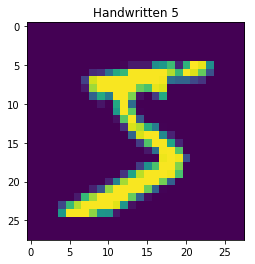

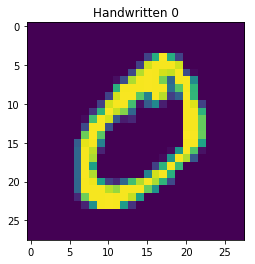

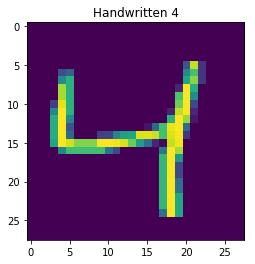

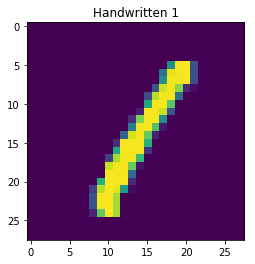

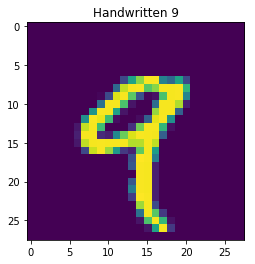

In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(float) - np.mean(x_train))/np.std(x_train)
x_test = (x_test.astype(float) - np.mean(x_test))/np.std(x_test)

for i in range(5):
  plt.imshow(x_train[i])
  plt.title(f'Handwritten {y_train[i]}')
  plt.show()

In [15]:
x_train = x_train.reshape(-1, 784)
x_test= x_test.reshape(-1, 784)

# one-hot encoding:
encoder = OneHotEncoder(categories='auto')
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

tf.logging.set_verbosity(tf.logging.ERROR)
nn = Sequential()
nn.add(Dense(100, activation = 'relu'))
nn.add(Dense(10, activation = 'softmax'))
nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = nn.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 3)
print (nn.summary())

Instructions for updating:
Colocations handled automatically by placer.
Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
60000/60000 [==============================] - 6s 108us/sample - loss: 0.2241 - acc: 0.9326 - val_loss: 0.1396 - val_acc: 0.9571
Epoch 2/3
60000/60000 [==============================] - 8s 126us/sample - loss: 0.1041 - acc: 0.9685 - val_loss: 0.1055 - val_acc: 0.9680
Epoch 3/3
60000/60000 [==============================] - 8s 131us/sample - loss: 0.0774 - acc: 0.9758 - val_loss: 0.0854 - val_acc: 0.9731
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  78500     
_________________________________________________________________
dense_1 (Dense)              multiple                  1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_____________

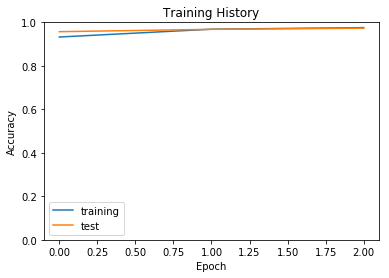

In [17]:
plt.plot(history.history['acc'], label = 'training')
plt.plot(history.history['val_acc'], label = 'test')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('Epoch')
plt.legend()
plt.show()

/usr/local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
class dqn_agent():
    def __init__(self):
        self.memory = []
        self.environment = gym.make('CartPole-v1')
        self.epsilon = 1
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.n_win = 150
        self.batch_size = 32

        # Deep Q Network
        self.model = Sequential()
        self.model.add(Dense(24, input_dim = 4, activation = 'tanh'))
        self.model.add(Dense(48, activation = 'tanh'))
        self.model.add(Dense(2))
        self.model.compile(loss = 'mse', optimizer=Adam(lr = 0.1, decay = 0.05))

    def choose_action(self, state):
        if (np.random.random() <= self.epsilon):
            return self.environment.action_space.sample()
        else:
            return np.argmax(self.model.predict(state))

    def update_weights(self):
        x, y = [], []

        batch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        for state, action, reward, next_state, done in batch:
            y_target = self.model.predict(state)
            if done:
                y_target[0][action] = reward 
            else:
                y_target[0][action] = reward + np.max(self.model.predict(next_state)[0])
            x.append(state[0])
            y.append(y_target[0])
            
        self.model.fit(np.array(x), np.array(y),  verbose = 0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def play_episode(self):

        i = 0
        done = False
        state = self.environment.reset().reshape(1,4)
        while not done:
            action = self.choose_action(state)
            next_state, reward, done, info = self.environment.step(action)
            next_state = next_state.reshape(1,4)
            self.memory.append((state, action, reward, next_state, done))
            state = next_state
            i += 1

        return i

    def train(self, episodes):
        scores = []
        for episode in range(episodes):
            score = self.play_episode()
            scores.append(score)

            if episode % 100 == 0:
                print(f'[Episode {episode}] - Mean survival time over last 100 episodes was {np.mean(scores[-100:])} moves.')
            if episode >= 100:
                if np.mean(scores[-100:]) > self.n_win:
                    print(f'Ran {episode} episodes. Solved after {episode - 100} trials ✔')
                    break
                
            self.update_weights()

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
agent = dqn_agent()

In [4]:
agent.train(1000)

[Episode 0] - Mean survival time over last 100 episodes was 103.0 moves.
[Episode 100] - Mean survival time over last 100 episodes was 23.35 moves.
[Episode 200] - Mean survival time over last 100 episodes was 56.33 moves.
[Episode 300] - Mean survival time over last 100 episodes was 120.28 moves.
[Episode 400] - Mean survival time over last 100 episodes was 138.42 moves.
Ran 453 episodes. Solved after 353 trials ✔


In [5]:
environment = gym.make('CartPole-v1')
state = environment.reset()
for i in range(200):
    environment.render()
    action = agent.choose_action(state.reshape(1,4))
    state, reward, done, info = environment.step(action) # take a random action
environment.close()